In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch

     |████████████████████████████████| 46.9 MB 1.5 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.3 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595741 sha256=c6ac40c97e5535d40d974340ba32fea83435a3551c4d5dfe66a8f93e5ccf8a88
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 754 kB 5.2 MB/s 
     |████████████████████████████████| 3.0 MB 34.2 MB/s 
     |████████████████████████████████| 895 kB 38.3 MB/s 


In [2]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-ne3qfxss
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-ne3qfxss
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=12771 sha256=5a4a06c1cb070aec48c157809fad35f240df9464be69cb3e123a07c6a3d838b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-skwfwq92/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [4]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [5]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [6]:
device = torch.device("cuda:0")

In [7]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [8]:
import pandas as pd
import numpy as np
import random
import time
import datetime
train_data = pd.read_csv('/content/drive/MyDrive/train_data.csv', encoding='cp949')
train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')

In [9]:
train_data

,comments,hate
0,현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,1
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,0
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,1
3,화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데,0
4,사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노,1
...,...,...
24187,잘난척좀그만해ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,0
24188,응 갈데 없어 ㅋㅋ,0
24189,너 돈은있니 ㅋㅋㅋㅋㅋㅋㅋ,0
24190,코휘향 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,0


In [10]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [11]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [12]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 15
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [13]:
TRAIN_SIZE = 0.9
TRAIN_LEN = len(train_data)
train_shuffle = train_data.sample(frac=1).reset_index(drop=True)
train = train_shuffle[:int(TRAIN_LEN*TRAIN_SIZE)]
test = train_shuffle[int(TRAIN_LEN*TRAIN_SIZE):]

In [14]:
dataset_train = train.values.tolist()
dataset_test = test.values.tolist()

In [15]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [16]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [18]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [19]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [20]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [21]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [22]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [23]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [24]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 0.5847914814949036 train acc 0.765625
epoch 1 batch id 201 loss 0.5315799117088318 train acc 0.7993625621890548
epoch 1 train acc 0.8211907380254155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 1 test acc 0.8871773785425102


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.31375816464424133 train acc 0.890625
epoch 2 batch id 201 loss 0.3911343216896057 train acc 0.8736784825870647
epoch 2 train acc 0.8854319403714566


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 2 test acc 0.8900556680161944


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.2990708649158478 train acc 0.875
epoch 3 batch id 201 loss 0.29165002703666687 train acc 0.9075715174129353
epoch 3 train acc 0.9181176686217009


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 3 test acc 0.8958122469635628


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.1663438379764557 train acc 0.921875
epoch 4 batch id 201 loss 0.17192348837852478 train acc 0.9375
epoch 4 train acc 0.9435483870967742


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 4 test acc 0.8978681680161944


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.08745692670345306 train acc 0.96875
epoch 5 batch id 201 loss 0.25929030776023865 train acc 0.9520366915422885
epoch 5 train acc 0.955232771260997


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 5 test acc 0.8990068319838056


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.12811161577701569 train acc 0.953125
epoch 6 batch id 201 loss 0.17315559089183807 train acc 0.9684390547263682
epoch 6 train acc 0.968841642228739


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 6 test acc 0.895495951417004


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.015800319612026215 train acc 1.0
epoch 7 batch id 201 loss 0.028897438198328018 train acc 0.9775342039800995
epoch 7 train acc 0.9786015395894428


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 7 test acc 0.8957173582995951


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.004293975420296192 train acc 1.0
epoch 8 batch id 201 loss 0.1487751454114914 train acc 0.9832089552238806
epoch 8 train acc 0.9841458944281525


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 8 test acc 0.8946735829959515


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.004025534726679325 train acc 1.0
epoch 9 batch id 201 loss 0.013781523331999779 train acc 0.9861629353233831
epoch 9 train acc 0.9876282991202346


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 9 test acc 0.8893281882591093


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.003401046385988593 train acc 1.0
epoch 10 batch id 201 loss 0.005668786354362965 train acc 0.9878731343283582
epoch 10 train acc 0.9900568181818182


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 10 test acc 0.9012525303643725


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.07908713817596436 train acc 0.984375
epoch 11 batch id 201 loss 0.0013615194475278258 train acc 0.9913712686567164
epoch 11 train acc 0.9924395161290323


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 11 test acc 0.8975518724696356


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.0007171701290644705 train acc 1.0
epoch 12 batch id 201 loss 0.0012372775236144662 train acc 0.9937810945273632
epoch 12 train acc 0.9944098240469208


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 12 test acc 0.8995129048582996


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.000526293006259948 train acc 1.0
epoch 13 batch id 201 loss 0.0010615031933411956 train acc 0.9939365671641791
epoch 13 train acc 0.9946847507331378


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 13 test acc 0.8995129048582996


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.00046384776942431927 train acc 1.0
epoch 14 batch id 201 loss 0.0006049350486136973 train acc 0.9958022388059702
epoch 14 train acc 0.9961510263929618


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 14 test acc 0.9003352732793523


  0%|          | 0/341 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.00042979526915587485 train acc 1.0
epoch 15 batch id 201 loss 0.0006470663356594741 train acc 0.9958022388059702
epoch 15 train acc 0.9960135630498533


  0%|          | 0/38 [00:00<?, ?it/s]

epoch 15 test acc 0.9011576417004049


In [27]:
data_test

In [28]:
test_input  = torch.utils.data.DataLoader(data_test, batch_size=1, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [48]:
test_acc = 0
labels = []
y_pred = []
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_input)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        labels.append(int(label))
        logits = out[0]
        logits = logits.detach().cpu().numpy()
        y_pred.append(np.argmax(logits))
        test_acc += calc_accuracy(out, label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2420 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [49]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [54]:
def plot_cm(labels, predictions, name, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (" + name + ')')
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1994
           1       0.71      0.75      0.73       426

    accuracy                           0.90      2420
   macro avg       0.83      0.84      0.83      2420
weighted avg       0.90      0.90      0.90      2420



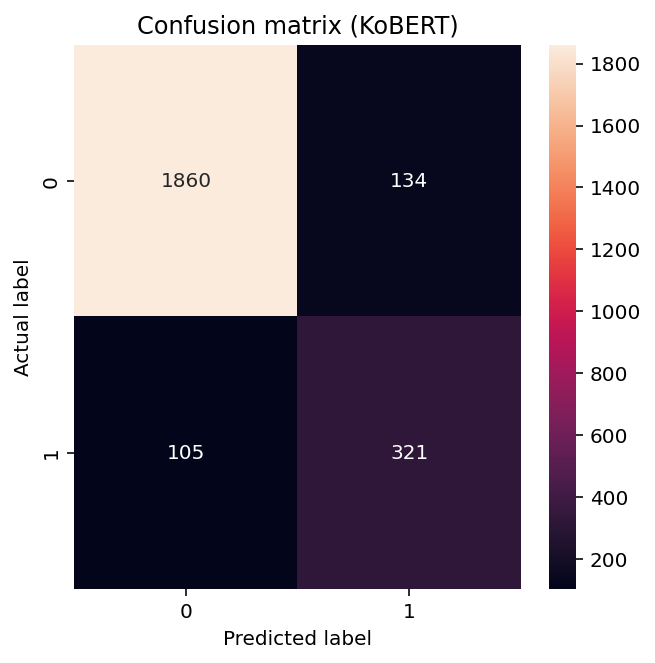

In [56]:
report = classification_report(y_pred, labels)
print(report)
plot_cm(y_pred, labels, 'KoBERT')

In [57]:
use = []
for i in range(1):
  text = '개 씨발 새끼들아!!!'
  use.append([text, 0])
use_set = BERTDataset(use, 0, 1, tok, max_len, True, False)
use_input = torch.utils.data.DataLoader(use_set, batch_size=1, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [65]:
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(use_input)): 
  token_ids = token_ids.long().to(device) 
  segment_ids = segment_ids.long().to(device) 
  valid_length= valid_length 
  out = model(token_ids, valid_length, segment_ids)
  prediction = out.cpu().detach().numpy().argmax()
  
  if prediction == 1:
    pred = '욕설 댓글'
  else:
    pred = '일반 댓글'
  print("'" + use[batch_id][0] + "'" + ' 의 분류 예측값은 ' + str(pred) + '입니다.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


'개 씨발 새끼들아!!!' 의 분류 예측값은 욕설 댓글입니다.
